In [44]:
# essentials
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import re
import string
from collections import Counter
import pickle

# NLP
import gensim
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.utils import to_categorical

# train test split 
from sklearn.model_selection import train_test_split

import config

In [45]:
small_data = True
seed = 42
input_size = config.PREVIOUS_WORDS_CONSIDERED * config.VECTOR_SIZE

In [46]:
model_dir = f"models/word2vecs/pwc{config.PREVIOUS_WORDS_CONSIDERED}-win{config.WINDOW}-vec{config.VECTOR_SIZE}-min{config.MIN_COUNT}"

try:
    os.makedirs(model_dir)
except(FileExistsError):
    print(f"WARNING: You will overwrite your models, because directory \"{model_dir}\" already exists.")

## Load the data

In [47]:
if small_data:
    data_path = "data/reviews_cleaned_sample.csv"
    vocabulary_filename = "vocabulary_small.pkl"
else:
    data_path = "data/reviews_cleaned.csv"
    vocabulary_filename = "vocabulary.pkl"

reviews_df = pd.read_csv(data_path, converters={'tokenized': pd.eval})

### Generating vocabulary

In [48]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jjasi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
all_words = []

for tokenized_reviews in reviews_df.tokenized:
    all_words.extend(tokenized_reviews)

In [50]:
vocabulary = [word for word, quantity in Counter(all_words).items() if quantity >= config.MIN_COUNT]
vocabulary.append(config.END_TOKEN)

In [51]:
vocabulary_size = len(vocabulary)
vocabulary_size

1918

In [52]:
with open(os.path.join(model_dir, vocabulary_filename), 'wb') as file:
    pickle.dump(vocabulary, file)

### Filtering tokens

In [53]:
# function to which filter token basing on the vocabulary

def filter_tokens(tokens, remove_stopwords=False):
    # removing rarely occurring words (< min_count)
    tokens = [token for token in tokens if token in vocabulary]

    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]

    # and adding [END] of document token at the end  
    tokens.append(config.END_TOKEN)

    return tokens

In [54]:
reviews_df["filter_tokens"] = reviews_df.tokenized.apply(filter_tokens)

In [55]:
reviews_df

review  positive  \
0     Flavia the Heretic is an undeniable work of ar...     False   
1     ROUEN PRIZES AND THE TRIUMPH OF "VILLA PARANOI...     False   
2     I liked the movie, first of all because it tol...     False   
3     Im watching it now on pink (Serbia TV station)...     False   
4     A warm, touching movie that has a fantasy-like...     False   
...                                                 ...       ...   
1495  I caught Evening in the cinema with a lady fri...     False   
1496  I originally scored Sarah's show with a nice f...     False   
1497  Users who have rated this movie so highly simp...     False   
1498  This is an exquisite film about the search for...     False   
1499  By God, it's been a long time since I saw this...     False   

                                             clean_text  \
0     flavia the heretic is an undeniable work of ar...   
1     rouen prizes and the triumph of villa paranoia...   
2     i liked the movie first of all because it told...   
3     im watching it now on pink serbia tv station a...   
4     a warm touching movie that has a fantasylike q...   
...                                                 ...   
1495  i caught evening in the cinema with a lady fri...   
1496  i originally scored sarahs show with a nice fa...   
1497  users who have rated this movie so highly simp...   
1498  this is an exquisite film about the search for...   
1499  by god its been a long time since i saw this p...   

                                              tokenized  \
0     [flavia, the, heretic, is, an, undeniable, wor...   
1     [rouen, prizes, and, the, triumph, of, villa, ...   
2     [i, liked, the, movie, first, of, all, because...   
3     [im, watching, it, now, on, pink, serbia, tv, ...   
4     [a, warm, touching, movie, that, has, a, fanta...   
...                                                 ...   
1495  [i, caught, evening, in, the, cinema, with, a,...   
1496  [i, originally, scored, sarahs, show, with, a,...   
1497  [users, who, have, rated, this, movie, so, hig...   
1498  [this, is, an, exquisite, film, about, the, se...   
1499  [by, god, its, been, a, long, time, since, i, ...   

                                          filter_tokens  
0     [the, is, an, work, of, art, and, probably, my...  
1     [and, the, of, the, favorite, film, of, the, g...  
2     [i, liked, the, movie, first, of, all, because...  
3     [im, watching, it, now, on, tv, and, i, must, ...  
4     [a, movie, that, has, a, by, the, high, imdb, ...  
...                                                 ...  
1495  [i, caught, evening, in, the, cinema, with, a,...  
1496  [i, originally, show, with, a, nice, fat, but,...  
1497  [who, have, rated, this, movie, so, highly, si...  
1498  [this, is, an, film, about, the, search, for, ...  
1499  [by, god, its, been, a, long, time, since, i, ...  

[1500 rows x 5 columns]

## Word embedding

In [56]:
word2vec = Word2Vec(reviews_df.filter_tokens, min_count=config.MIN_COUNT, window=config.WINDOW, vector_size=config.VECTOR_SIZE)

In [57]:
word2vec.wv.vector_size

200

In [58]:
word2vec.wv.similar_by_word("bad")

[('but', 0.9903587102890015),
 ('funny', 0.9876430630683899),
 ('not', 0.9871251583099365),
 ('its', 0.9870350360870361),
 ('expecting', 0.9852882623672485),
 ('too', 0.9835497140884399),
 ('enjoyed', 0.9834569692611694),
 ('worth', 0.9833132028579712),
 ('thats', 0.9832863211631775),
 ('ok', 0.9824593663215637)]

In [59]:
with open(os.path.join(model_dir, "word2vec.pkl"), 'wb') as file:
    pickle.dump(word2vec, file)

In [60]:
X_words = []
y_words = []

for tokenized_review in reviews_df.filter_tokens:
    # iterating over indices for the first which has enough words before (previous_words_considered)
    # until the last one
    for index in range(config.PREVIOUS_WORDS_CONSIDERED, len(tokenized_review)): 
        x = tokenized_review[index-config.PREVIOUS_WORDS_CONSIDERED: index]
        y = tokenized_review[index]

        print(x, y)
        X_words.append(tokenized_review[index-config.PREVIOUS_WORDS_CONSIDERED: index])
        y_words.append(tokenized_review[index])

['the', 'is', 'an'] work
['is', 'an', 'work'] of
['an', 'work', 'of'] art
['work', 'of', 'art'] and
['of', 'art', 'and'] probably
['art', 'and', 'probably'] my
['and', 'probably', 'my'] number
['probably', 'my', 'number'] one
['my', 'number', 'one'] to
['number', 'one', 'to'] state
['one', 'to', 'state'] that
['to', 'state', 'that'] the
['state', 'that', 'the'] cinema
['that', 'the', 'cinema'] is
['the', 'cinema', 'is'] underrated
['cinema', 'is', 'underrated'] and
['is', 'underrated', 'and'] not
['underrated', 'and', 'not'] to
['and', 'not', 'to'] be
['not', 'to', 'be'] this
['to', 'be', 'this'] is
['be', 'this', 'is'] an
['this', 'is', 'an'] intelligent
['is', 'an', 'intelligent'] and
['an', 'intelligent', 'and'] complex
['intelligent', 'and', 'complex'] film
['and', 'complex', 'film'] beautifully
['complex', 'film', 'beautifully'] realized
['film', 'beautifully', 'realized'] and
['beautifully', 'realized', 'and'] 
['realized', 'and', '\x96'] surprise
['and', '\x96', 'surprise'] 
[

In [61]:
len(X_words)

166827

In [62]:
label_to_index = {word: index for index, word in enumerate(vocabulary)}

In [63]:
X = np.zeros((len(X_words), input_size))

for index, x in enumerate(X_words):
    numpy_x = np.array([])
    for word in x:
        numpy_x = np.append(numpy_x, word2vec.wv.get_vector(word))

    X[index, ...]  = numpy_x

In [64]:
y = np.zeros((len(y_words), vocabulary_size))

for index, label in enumerate(y_words):
    y[index, label_to_index[label]] += 1

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=seed)

In [66]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150144, 600), (16683, 600), (150144, 1918), (16683, 1918))

In [67]:
model = Sequential()

model.add(Input(input_size))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(vocabulary_size, activation="sigmoid"))

model.build()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                38464     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 1918)              247422    
                                                                 
Total params: 294,206
Trainable params: 294,206
Non-trainable params: 0
_________________________________________________________________


In [68]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=config.LABEL_SMOOTHING_RATIO)
# loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE)

In [69]:
model.compile(loss=loss, optimizer=optimizer, metrics=["acc"])

In [70]:
training = model.fit(X_train, y_train, validation_split=0.1, batch_size=config.BATCH_SIZE, epochs=config.EPOCHS)

Epoch 1/64
1056/1056 [==============================] - 11s 8ms/step - loss: 6.3817 - acc: 0.0680 - val_loss: 6.2493 - val_acc: 0.0754
Epoch 2/64
1056/1056 [==============================] - 7s 7ms/step - loss: 6.2339 - acc: 0.0799 - val_loss: 6.1623 - val_acc: 0.0875
Epoch 3/64
1056/1056 [==============================] - 7s 6ms/step - loss: 6.1866 - acc: 0.0850 - val_loss: 6.1385 - val_acc: 0.0906
Epoch 4/64
1056/1056 [==============================] - 7s 7ms/step - loss: 6.1615 - acc: 0.0867 - val_loss: 6.1239 - val_acc: 0.0930
Epoch 5/64
1056/1056 [==============================] - 8s 7ms/step - loss: 6.1409 - acc: 0.0882 - val_loss: 6.1003 - val_acc: 0.0950
Epoch 6/64
1056/1056 [==============================] - 8s 7ms/step - loss: 6.1242 - acc: 0.0902 - val_loss: 6.1023 - val_acc: 0.0968
Epoch 7/64
1056/1056 [==============================] - 7s 7ms/step - loss: 6.1128 - acc: 0.0904 - val_loss: 6.0904 - val_acc: 0.0974
Epoch 8/64
1056/1056 [==============================] - 7s 7m

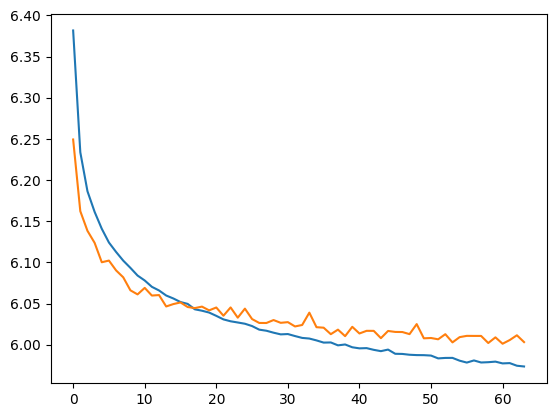

In [71]:
plt.plot(range(config.EPOCHS), training.history["loss"])
plt.plot(range(config.EPOCHS), training.history["val_loss"])

In [74]:
model_filename = f"predicor-lr{config.LEARNING_RATE}-batch{config.BATCH_SIZE}.h5"

model.save(os.path.join(model_dir, model_filename))

In [75]:
model.evaluate(X_test, y_test)

522/522 [==============================] - 2s 2ms/step - loss: 6.0146 - acc: 0.1084


[6.014614105224609, 0.10843373835086823]